### Loading the Dataset

In [15]:
from datasets import load_dataset

smt_instr_dataset = load_dataset("ritwik-ghosh/SMT_Fine-tuning_dataset")
smt_instr_dataset


DatasetDict({
    train: Dataset({
        features: ['Context', 'instruction', 'instruction_score', 'response', 'response_score'],
        num_rows: 639
    })
})

### Visualising Sample-length distribution across the Dataset

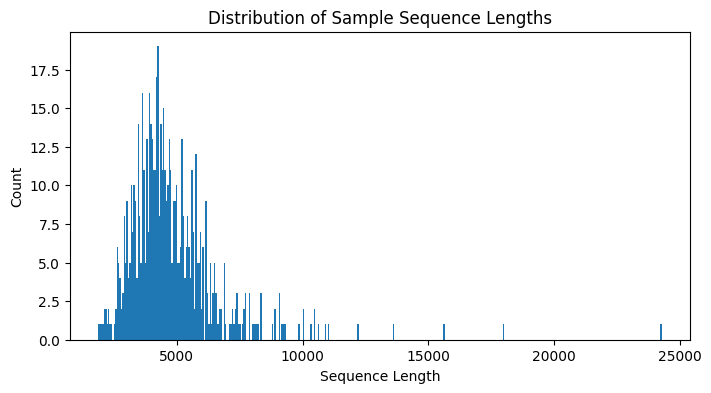

Number of outliers : 32


In [16]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj, bin_size):

    # Initializing a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Looping over the dataset and to the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['Context']) + len(example["instruction"]) + len(example["response"]))
        # filters out outliers
        if sequence_lengths[idx] > 8000:
          too_long.append(idx)
    
    # Plotting the histogram
    plt.figure(figsize=(8,4))
    plt.hist(sequence_lengths, bins=bin_size)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Sample Sequence Lengths')
    plt.show()

    return too_long
indexes_to_drop = plot_sequence_lengths(smt_instr_dataset, 400)
print(f"Number of outliers : {len(indexes_to_drop)}")

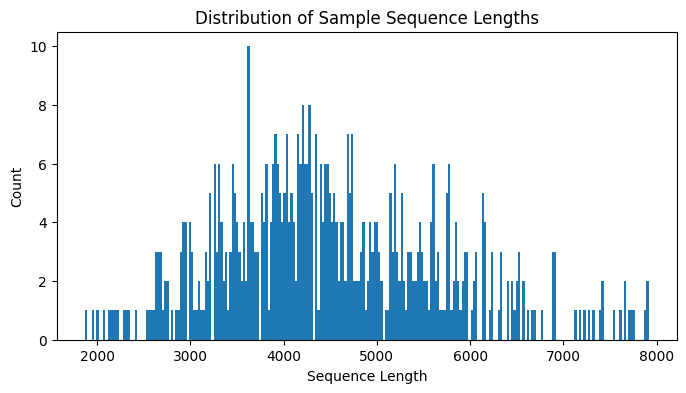

DatasetDict({
    train: Dataset({
        features: ['Context', 'instruction', 'instruction_score', 'response', 'response_score'],
        num_rows: 546
    })
    test: Dataset({
        features: ['Context', 'instruction', 'instruction_score', 'response', 'response_score'],
        num_rows: 61
    })
})

In [17]:
smt_instr_dataset_norm = smt_instr_dataset["train"].select(i for i in range(len(smt_instr_dataset["train"])) if i not in set(indexes_to_drop))
smt_instr_dataset_norm
smt_instr_dataset_train_test = smt_instr_dataset_norm.train_test_split(test_size=0.1)
plot_sequence_lengths(smt_instr_dataset_train_test, 250)
smt_instr_dataset_train_test

### Setting the Format of the Instruction-Dataset

In [18]:
def formatting_func(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context."
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['Context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}
formatted_dataset = smt_instr_dataset_train_test.map(formatting_func)
formatted_dataset

Map: 100%|██████████| 61/61 [00:00<00:00, 6874.43 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Context', 'instruction', 'instruction_score', 'response', 'response_score', 'text'],
        num_rows: 546
    })
    test: Dataset({
        features: ['Context', 'instruction', 'instruction_score', 'response', 'response_score', 'text'],
        num_rows: 61
    })
})

In [19]:
(formatted_dataset["test"][0])

{'Context': 'Figure 1 Status and developments for soft solders addressing elevated temperatures\n\n|180° C < T liquidus < 280° C| | | |\n|---|---|---|---|\n| |Sn-based solders|SAC xxTuse< 130°C| |\n|Developments:| |Au, Al, Zn-based solders|Different advantages/shortcomings T use< 200-300°C|\n| |Highly creep resistant Sn based,|e.g. Innolot, HT1,|Sn-Ag-Cu-Bi-Sb-Ni, Tuse< 160°C|\n\nThe latter properties allow their use at elevated temperatures, as their fatigue properties are improved. They are already in series production use. However, a unique replacement for high-lead solder is not yet in sight. Other technologies, which address not only a simple replacement, but also offer new high temperature properties in terms of creep and fatigue resistance are under development. As shown in Figure 2, Ag-sintering and transient liquid phase (TLP) soldering need also to be mentioned.\n\nUsing an interlayer is one major characteristic of the TLP bonding process. In a difference from pure diffusion 

## Setting up Model Configuration 

#### LoRA Config

In [20]:
import torch
import transformers
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_id = "Qwen/Qwen2.5-0.5B"
device = "cuda:0"

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


quant_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    #device_map = {"" :0}
).to(device)

'''if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    quant_model = torch.nn.DataParallel(quant_model)'''

#model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})


`low_cpu_mem_usage` was None, now default to True since model is quantized.


1

### Qwen 2.5 architecture

In [21]:
print(quant_model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=896, out_features=896, bias=True)
          (k_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (v_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (o_proj): Linear4bit(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear4bit(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    

In [22]:
peft_model = get_peft_model(quant_model, lora_config)

### Estimating trainable parameters

In [23]:
def net_trainable_params(model):    #prints the net trainable parameters for fine-tuning 
    all_params = 0
    trainable_params = 0
    for param in model.parameters():
        all_params += param.numel()
        if param.requires_grad == True:
            trainable_params += param.numel()
    
    print(f"Trainable Parameters: {trainable_params} || Total Parameters: {all_params}, || % trainable: {100*trainable_params/all_params}")
    
net_trainable_params(peft_model)

Trainable Parameters: 1081344 || Total Parameters: 316200832, || % trainable: 0.34198012483408013


### Hyperparameter Configuration

In [24]:
from trl import SFTTrainer, SFTConfig


def tokenize_function(examples):
    tokens = tokenizer(examples["text"], truncation=True, padding=True, max_length=512, return_tensors="pt")
    return {key: val.to(device) for key, val in tokens.items()}  # Move tokens to GPU

    #return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

tokenized_train_dataset = formatted_dataset["train"].map(tokenize_function, batched=True)
tokenized_test_dataset = formatted_dataset["test"].map(tokenize_function, batched=True)


Map:   0%|          | 0/546 [00:00<?, ? examples/s]

Map: 100%|██████████| 61/61 [00:00<00:00, 2399.51 examples/s]


In [ ]:

#Move Dataset to the same GPU
def move_to_gpu(example):
    return {key: torch.tensor(val).to(device) if isinstance(val, list) else val for key, val in example.items()}

formatted_dataset["train"] = formatted_dataset["train"].map(move_to_gpu)
formatted_dataset["test"] = formatted_dataset["test"].map(move_to_gpu)

"""if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    quant_model = torch.nn.DataParallel(quant_model)"""

supervised_finetuning_trainer = SFTTrainer(
    peft_model,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    args=SFTConfig(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        max_steps=5000,
        output_dir="./SMT-LLM",
        optim="paged_adamw_8bit",
        fp16=True,
        dataset_text_field="text",
        num_train_epochs=2
        
    ),
    processing_class=tokenizer,
    #tokenizer=tokenizer, #depricated 
    peft_config=lora_config,
    formatting_func=formatting_func,
    #max_seq_length=512
)

Map: 100%|██████████| 61/61 [00:00<00:00, 3205.17 examples/s]


### Kicking off the Training

In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [27]:
supervised_finetuning_trainer.train()

RuntimeError: Caught RuntimeError in replica 1 on device 1.
Original Traceback (most recent call last):
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 83, in _worker
    output = module(*input, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/peft/peft_model.py", line 1745, in forward
    return self.base_model(
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/peft/tuners/tuners_utils.py", line 197, in forward
    return self.model.forward(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/transformers/models/qwen2/modeling_qwen2.py", line 1165, in forward
    outputs = self.model(
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/transformers/models/qwen2/modeling_qwen2.py", line 895, in forward
    layer_outputs = decoder_layer(
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/transformers/models/qwen2/modeling_qwen2.py", line 623, in forward
    hidden_states, self_attn_weights, present_key_value = self.self_attn(
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/transformers/models/qwen2/modeling_qwen2.py", line 501, in forward
    query_states = self.q_proj(hidden_states)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/peft/tuners/lora/bnb.py", line 496, in forward
    result = self.base_layer(x, *args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/ritwik/.local/lib/python3.10/site-packages/bitsandbytes/nn/modules.py", line 484, in forward
    return bnb.matmul_4bit(x, self.weight.t(), bias=bias, quant_state=self.weight.quant_state).to(inp_dtype)
  File "/home/ritwik/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py", line 533, in matmul_4bit
    return MatMul4Bit.apply(A, B, out, bias, quant_state)
  File "/home/ritwik/.local/lib/python3.10/site-packages/torch/autograd/function.py", line 598, in apply
    return super().apply(*args, **kwargs)  # type: ignore[misc]
  File "/home/ritwik/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py", line 462, in forward
    output = torch.nn.functional.linear(A, F.dequantize_4bit(B, quant_state).to(A.dtype).t(), bias)
  File "/home/ritwik/.local/lib/python3.10/site-packages/bitsandbytes/functional.py", line 1362, in dequantize_4bit
    is_on_gpu([A, absmax, out])
  File "/home/ritwik/.local/lib/python3.10/site-packages/bitsandbytes/functional.py", line 469, in is_on_gpu
    raise RuntimeError(
RuntimeError: Input tensors need to be on the same GPU, but found the following tensor and device combinations:
 [(torch.Size([1, 401408]), device(type='cuda', index=1)), (torch.Size([12544]), device(type='cuda', index=0)), (torch.Size([896, 896]), device(type='cuda', index=1))]


### Pushing the Weights to HF Hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.push_to_hub("ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned", private=True)

model.safetensors: 100%|██████████| 1.98G/1.98G [01:02<00:00, 31.5MB/s]


CommitInfo(commit_url='https://huggingface.co/ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned/commit/7c0c2a8e908fd4fea6772874f51bd4bbf95202af', commit_message='Upload Qwen2ForCausalLM', commit_description='', oid='7c0c2a8e908fd4fea6772874f51bd4bbf95202af', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned', endpoint='https://huggingface.co', repo_type='model', repo_id='ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned'), pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned_tokenizer")

tokenizer.json: 100%|██████████| 11.4M/11.4M [00:00<00:00, 25.1MB/s]


CommitInfo(commit_url='https://huggingface.co/ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned_tokenizer/commit/45f194377940a70527713ba6c7aea04a64a30213', commit_message='Upload tokenizer', commit_description='', oid='45f194377940a70527713ba6c7aea04a64a30213', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned_tokenizer', endpoint='https://huggingface.co', repo_type='model', repo_id='ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned_tokenizer'), pr_revision=None, pr_num=None)

## Inference from the trained model

In [ ]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

#lora_config = LoraConfig.from_pretrained("ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained("ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned_tokenizer")
model = AutoModelForCausalLM.from_pretrained(
    "ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned",
    #quantization_config=bnb_config,
    device_map={"":0})

Some weights of the model checkpoint at ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned were not used when initializing Qwen2ForCausalLM: ['model.layers.0.self_attn.q_proj.base_layer.bias', 'model.layers.0.self_attn.q_proj.base_layer.weight', 'model.layers.0.self_attn.q_proj.lora_A.default.weight', 'model.layers.0.self_attn.q_proj.lora_B.default.weight', 'model.layers.0.self_attn.v_proj.base_layer.bias', 'model.layers.0.self_attn.v_proj.base_layer.weight', 'model.layers.0.self_attn.v_proj.lora_A.default.weight', 'model.layers.0.self_attn.v_proj.lora_B.default.weight', 'model.layers.1.self_attn.q_proj.base_layer.bias', 'model.layers.1.self_attn.q_proj.base_layer.weight', 'model.layers.1.self_attn.q_proj.lora_A.default.weight', 'model.layers.1.self_attn.q_proj.lora_B.default.weight', 'model.layers.1.self_attn.v_proj.base_layer.bias', 'model.layers.1.self_attn.v_proj.base_layer.weight', 'model.layers.1.self_attn.v_proj.lora_A.default.weight', 'model.layers.1.self_attn.v_proj.lora_B.default

In [ ]:
from IPython.display import display, Markdown

model_id = "Qwen/Qwen2.5-0.5B"
base_model = AutoModelForCausalLM.from_pretrained(model_id).to("cuda:0")

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  base_outputs = base_model.generate(**inputs, max_new_tokens=100)
  display(Markdown((tokenizer.decode(base_outputs[0], skip_special_tokens=True))))
  
  tuned_outputs = model.generate(**inputs, max_new_tokens=50)
  print("---- NON-INSTRUCT-TUNED-MODEL ----")
  display(Markdown((tokenizer.decode(tuned_outputs[0], skip_special_tokens=True))))

In [ ]:
make_inference(instruction="How to accurately predict the surface tension of a lead-free solder?")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
How to accurately predict the surface tension of a lead-free solder?

### Response: 
To accurately predict the surface tension of a lead-free solder, you can follow these steps:

1. **Determine the composition of the solder**: The surface tension of a lead-free solder is influenced by its composition. Lead-free solder typically contains lead, tin, and other metals. The specific composition will determine the surface tension.

2. **Measure the surface tension**: Use a surface tension meter or a specialized tool to measure the surface tension of the solder. This will give you a precise value for the

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


---- NON-INSTRUCT-TUNED-MODEL ----


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
How to accurately predict the surface tension of a lead-free solder?

### Response: 
与其与其与其与与其与与其与与其与与其 (与其 (与其与与其与其与其 (与其 (与其 (与其 (与其 (与其 (与其 or与与其与其与其与其n与其one钗与其n与其-与其-与其-与其